In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/DM

/content/drive/MyDrive/DM


In [3]:
import glob
import cv2
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import torch
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, Birch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, Birch, AgglomerativeClustering
import numpy as np
from sklearn.decomposition import PCA

##Question 1

In [4]:
source_folders = ['/content/drive/MyDrive/DM/Cropped/n02090379-redbone/', '/content/drive/MyDrive/DM/Cropped/n02097047-miniature_schnauzer', '/content/drive/MyDrive/DM/Cropped/n02104365-schipperke', '/content/drive/MyDrive/DM/Cropped/n02112018-Pomeranian']
destination_folder = '/content/drive/MyDrive/DM/Resized/'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
target_size = (224, 224)

for source_folder in source_folders:
    image_files = os.listdir(source_folder)
    for image_file in image_files:
        image_path = os.path.join(source_folder, image_file)
        img = Image.open(image_path)
        resized_img = img.resize(target_size)
        destination_path = os.path.join(destination_folder, image_file)
        resized_img.save(destination_path)

print("Resizing and saving complete.")


Resizing and saving complete.


In [5]:
def extract_resnet18_features(image_path, model, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        features = model(input_image)

    return features.squeeze().cpu().numpy()

source_folders = [
    '/content/drive/MyDrive/DM/Cropped/n02090379-redbone/',
    '/content/drive/MyDrive/DM/Cropped/n02097047-miniature_schnauzer',
    '/content/drive/MyDrive/DM/Cropped/n02104365-schipperke',
    '/content/drive/MyDrive/DM/Cropped/n02112018-Pomeranian'
]

resnet18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = resnet18.to(device)
features_dict = {}
for source_folder in source_folders:
    class_name = os.path.basename(os.path.normpath(source_folder))
    features_list = []
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_path = os.path.join(source_folder, filename)
            features = extract_resnet18_features(image_path, resnet18, device)
            features_list.append(features)
    features_array = np.array(features_list)
    features_dict[class_name] = features_array
    print(f"Shape of features array for class '{class_name}':", features_array.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shape of features array for class 'n02090379-redbone': (151, 512)
Shape of features array for class 'n02097047-miniature_schnauzer': (162, 512)
Shape of features array for class 'n02104365-schipperke': (171, 512)
Shape of features array for class 'n02112018-Pomeranian': (223, 512)


In [6]:
print(len(features_dict['n02090379-redbone']))

151


##Question 2

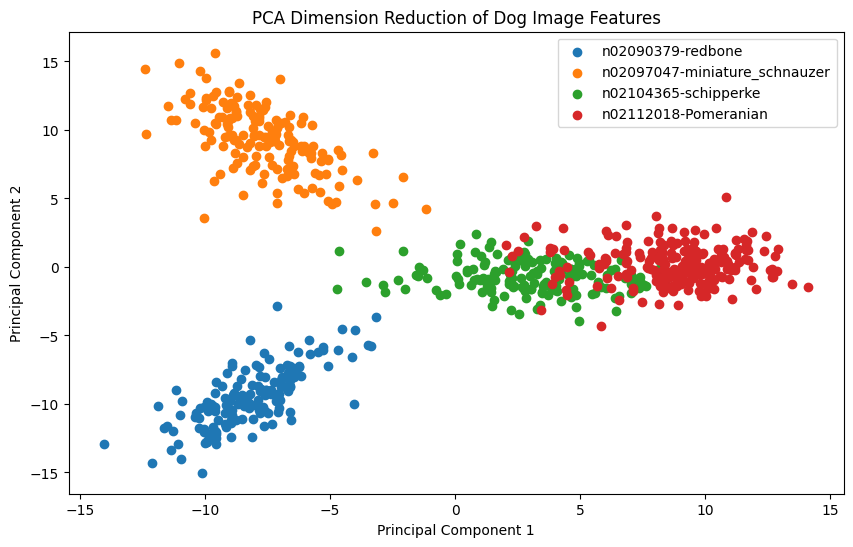

In [7]:
all_features = np.concatenate(list(features_dict.values()), axis=0)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features)

plt.figure(figsize=(10, 6))
counter = 0

for class_name, features in features_dict.items():
    indices = range(counter, counter + len(features))
    plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=class_name)
    counter += len(features)

plt.title('PCA Dimension Reduction of Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


##Question 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


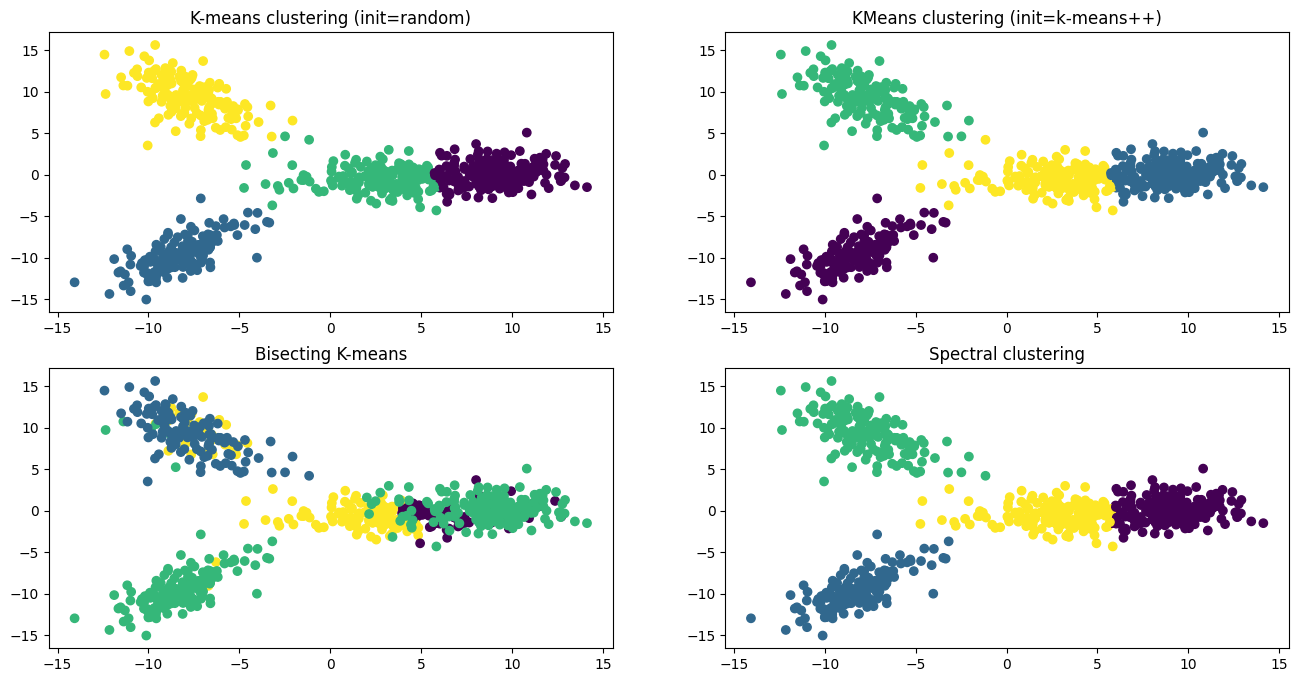

In [8]:
all_features = np.concatenate(list(features_dict.values()), axis=0)

# Apply PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features)

# K-means clustering with init='random'
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42)
kmeans_labels_random = kmeans_random.fit_predict(reduced_features)

# KMeans with init='k-means++'
kmeans_kmeans_plusplus = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels_kmeans_plusplus = kmeans_kmeans_plusplus.fit_predict(reduced_features)

# Bisecting K-means
bisecting_kmeans = Birch(n_clusters=4, threshold=0.01, branching_factor=50)
bisecting_kmeans_labels = bisecting_kmeans.fit_predict(reduced_features)

# Spectral clustering with default parameters
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42)
spectral_labels = spectral_clustering.fit_predict(reduced_features)

# Plot the clustered data
plt.figure(figsize=(16, 8))

# Plot K-means clustering with init='random'
plt.subplot(2, 2, 1)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels_random, cmap='viridis')
plt.title('K-means clustering (init=random)')

# Plot KMeans with init='k-means++'
plt.subplot(2, 2, 2)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels_kmeans_plusplus, cmap='viridis')
plt.title('KMeans clustering (init=k-means++)')

# Plot Bisecting K-means
plt.subplot(2, 2, 3)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=bisecting_kmeans_labels, cmap='viridis')
plt.title('Bisecting K-means')

# Plot Spectral clustering
plt.subplot(2, 2, 4)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=spectral_labels, cmap='viridis')
plt.title('Spectral clustering')

plt.show()


##Question 3

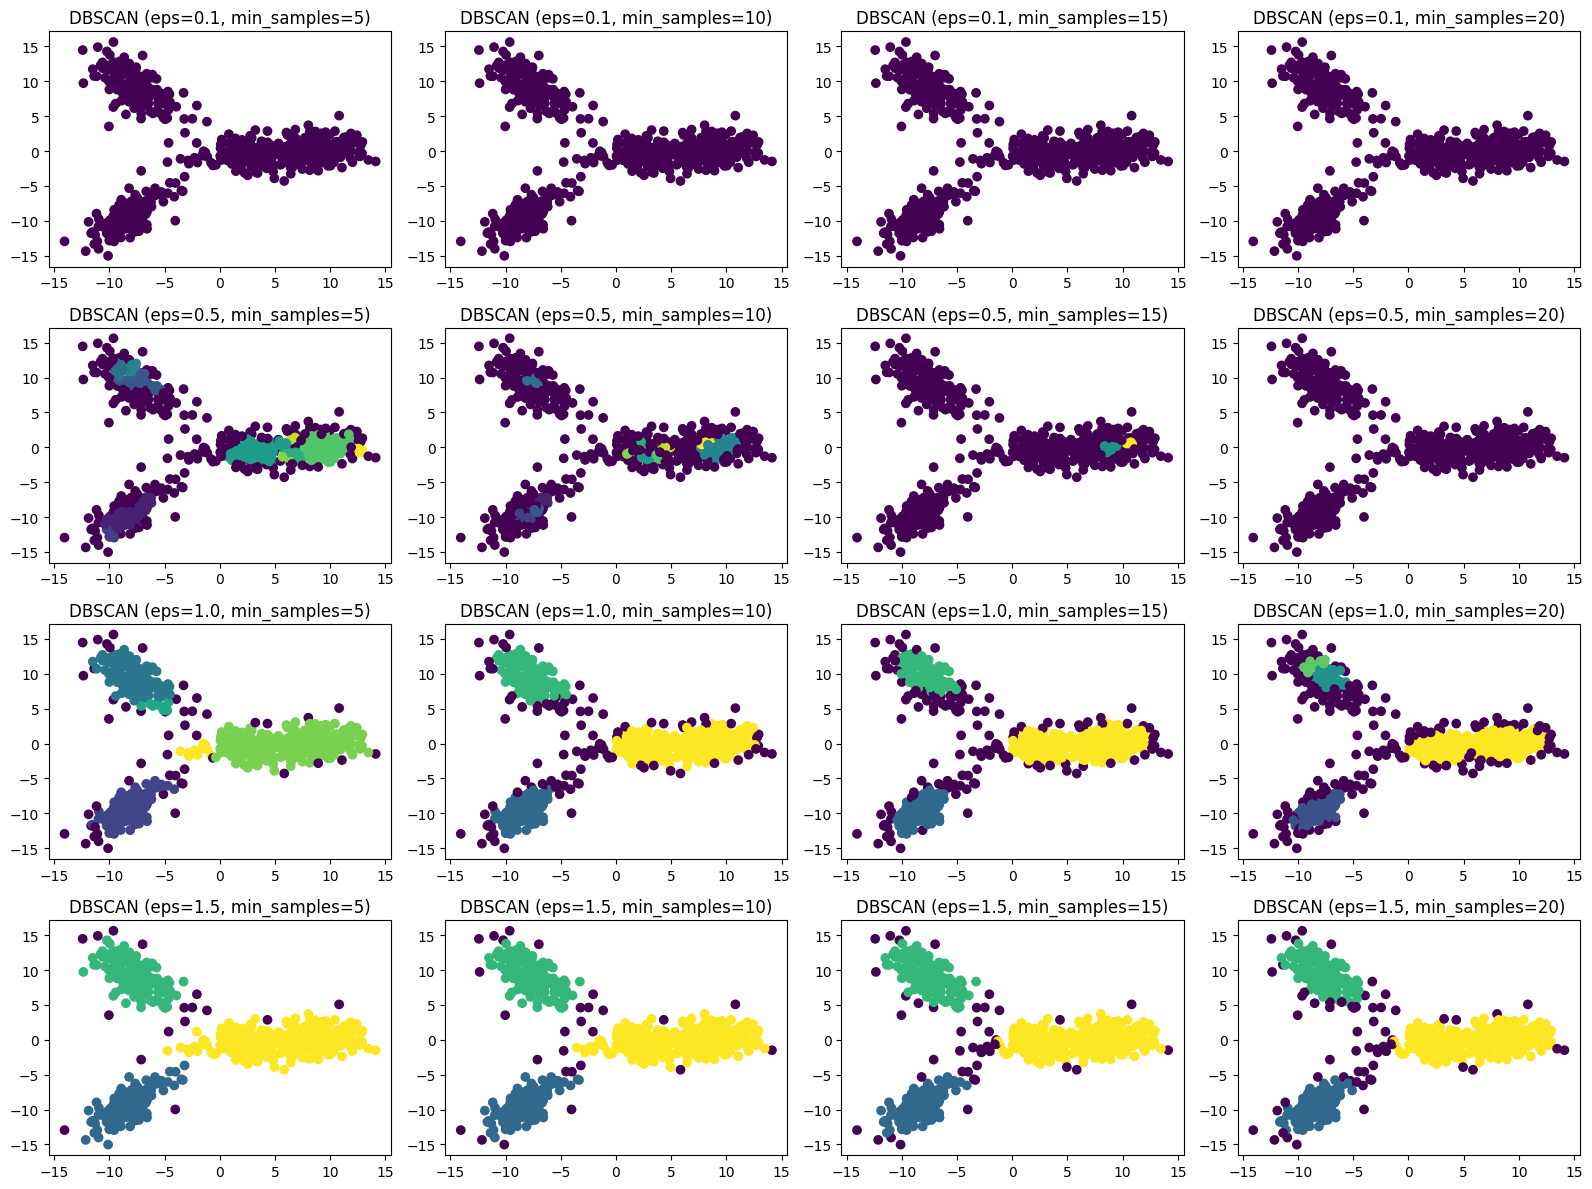

In [9]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Concatenate all feature arrays into a single matrix
all_features = np.concatenate(list(features_dict.values()), axis=0)

# Apply PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features)

# Experiment with different eps and min_samples values
eps_values = [0.1, 0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15, 20]

# Plot the results for different parameter values
plt.figure(figsize=(16, 12))

plot_index = 1
for eps in eps_values:
    for min_samples in min_samples_values:
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(reduced_features)

        # Plot the clustered data
        plt.subplot(len(eps_values), len(min_samples_values), plot_index)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=dbscan_labels, cmap='viridis')
        plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples})')

        plot_index += 1

plt.tight_layout()
plt.show()


##Question 3

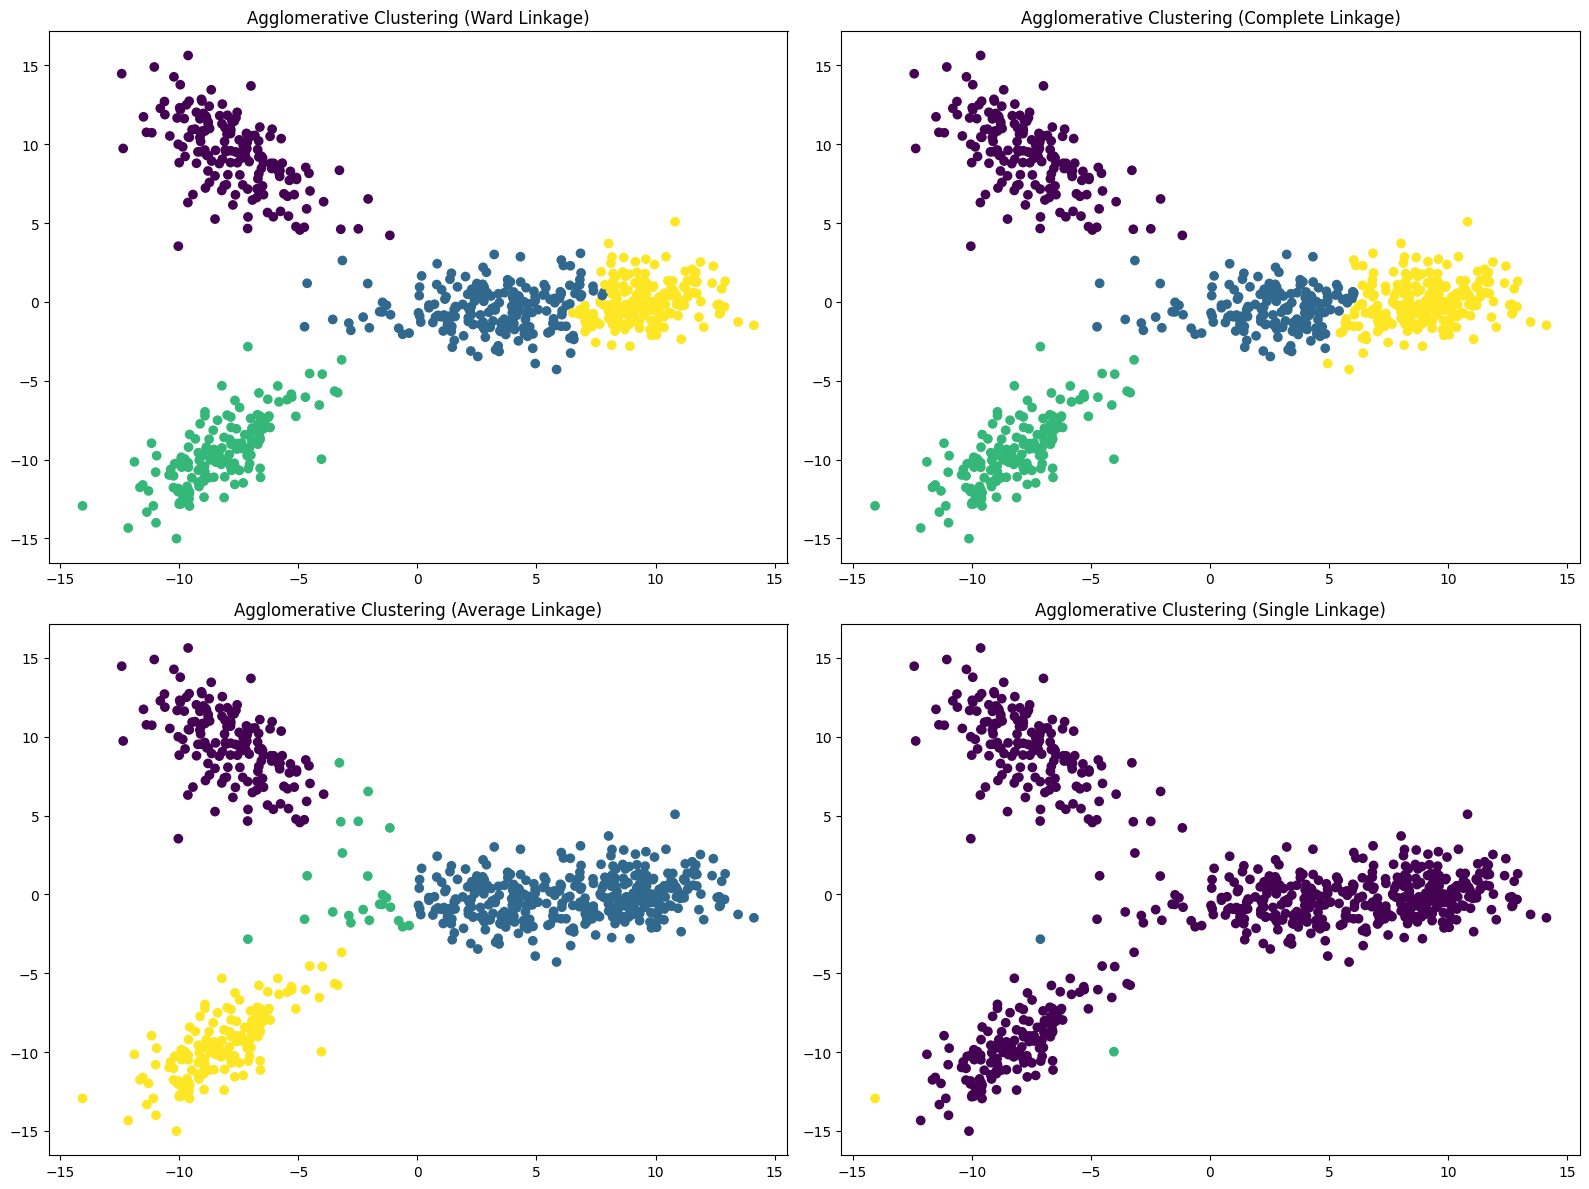

In [10]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

# Concatenate all feature arrays into a single matrix
all_features = np.concatenate(list(features_dict.values()), axis=0)

# Apply PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features)

# Define the linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']

# Plot the results for different linkage methods
plt.figure(figsize=(16, 12))

plot_index = 1
for linkage_method in linkage_methods:
    # Perform Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=4, linkage=linkage_method)
    agglomerative_labels = agglomerative.fit_predict(reduced_features)

    # Plot the clustered data
    plt.subplot(2, 2, plot_index)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=agglomerative_labels, cmap='viridis')
    plt.title(f'Agglomerative Clustering ({linkage_method.capitalize()} Linkage)')

    plot_index += 1

plt.tight_layout()
plt.show()


##Question 4

In [11]:
all_features = np.concatenate(list(features_dict.values()), axis=0)

# Apply PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features)

# Clustering methods
methods = {
    'KMeans (Random Init)': KMeans(n_clusters=4, init='random', random_state=42),
    'KMeans (k-means++)': KMeans(n_clusters=4, init='k-means++', random_state=42),
    'Bisecting KMeans': Birch(n_clusters=4, threshold=0.01, branching_factor=50),
    'Spectral Clustering': SpectralClustering(n_clusters=4, random_state=42),
    'Agglomerative (Single Link)': AgglomerativeClustering(n_clusters=4, linkage='single'),
    'Agglomerative (Complete Link)': AgglomerativeClustering(n_clusters=4, linkage='complete'),
    'Agglomerative (Group Average)': AgglomerativeClustering(n_clusters=4, linkage='average'),
    'Agglomerative (Ward)': AgglomerativeClustering(n_clusters=4, linkage='ward')
}

fowlkes_mallows_scores = {}
silhouette_scores = {}

# Perform clustering and evaluate each method
for method_name, method in methods.items():

    labels = method.fit_predict(reduced_features)

    # Ensure the number of samples in labels_true matches the number of samples in labels_pred
    labels_true = np.concatenate([np.full(len(features), i) for i, features in enumerate(features_dict.values())])

    # Fowlkes-Mallows Index
    fm_score = fowlkes_mallows_score(labels_true=labels_true, labels_pred=labels)
    fowlkes_mallows_scores[method_name] = fm_score

    # Silhouette Coefficient
    sil_score = silhouette_score(reduced_features, labels)
    silhouette_scores[method_name] = sil_score

# Rank methods based on Fowlkes-Mallows Index
ranked_methods_fm = sorted(fowlkes_mallows_scores.keys(), key=lambda k: fowlkes_mallows_scores[k], reverse=True)

# Rank methods based on Silhouette Coefficient
ranked_methods_silhouette = sorted(silhouette_scores.keys(), key=lambda k: silhouette_scores[k], reverse=True)

print("Fowlkes-Mallows Scores:")
for method_name in ranked_methods_fm:
    print(f"{method_name}: {fowlkes_mallows_scores[method_name]:.4f}")

print("\nSilhouette Coefficient Scores:")
for method_name in ranked_methods_silhouette:
    print(f"{method_name}: {silhouette_scores[method_name]:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fowlkes-Mallows Scores:
KMeans (k-means++): 0.8552
Spectral Clustering: 0.8533
KMeans (Random Init): 0.8526
Agglomerative (Complete Link): 0.8403
Agglomerative (Ward): 0.8242
Agglomerative (Group Average): 0.7736
Agglomerative (Single Link): 0.5036
Bisecting KMeans: 0.4794

Silhouette Coefficient Scores:
KMeans (k-means++): 0.6338
KMeans (Random Init): 0.6336
Spectral Clustering: 0.6324
Agglomerative (Complete Link): 0.6280
Agglomerative (Ward): 0.6161
Agglomerative (Group Average): 0.5563
Agglomerative (Single Link): -0.0714
Bisecting KMeans: -0.1390
